# AutoML with AutoGluon for Timeseries Data

In [1]:
# get dataset
!wget https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/all/online-retail-dataset.csv -P dataset

--2023-06-24 12:53:01--  https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/all/online-retail-dataset.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45038760 (43M) [text/plain]
Saving to: ‘dataset/online-retail-dataset.csv’

online-retail-datas 100%[===================>]  42.95M   788KB/s    in 28s     

2023-06-24 12:53:33 (1.55 MB/s) - ‘dataset/online-retail-dataset.csv’ saved [45038760/45038760]



## Single Variate Forecasting

In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd
import seaborn as sns

2023-06-24 20:48:40.020707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
SEED = 42
MODEL_PATH = 'model'

### Data Preprocessing

In [3]:
df = pd.read_csv('dataset/online-retail-dataset.csv')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


|  | InvoiceNo | StockCode | Description | Quantity | InvoiceDate | UnitPrice | CustomerID | Country |
| -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | 536365 | 85123A | WHITE HANGING HEART T-LIGHT HOLDER | 6 | 12/1/2010 8:26 | 2.55 | 17850.0 | United Kingdom |
| 1 | 536365 | 71053 | WHITE METAL LANTERN | 6 | 12/1/2010 8:26 | 3.39 | 17850.0 | United Kingdom |
| 2 | 536365 | 84406B | CREAM CUPID HEARTS COAT HANGER | 8 | 12/1/2010 8:26 | 2.75 | 17850.0 | United Kingdom |
| 3 | 536365 | 84029G | KNITTED UNION FLAG HOT WATER BOTTLE | 6 | 12/1/2010 8:26 | 3.39 | 17850.0 | United Kingdom |
| 4 | 536365 | 84029E | RED WOOLLY HOTTIE WHITE HEART. | 6 | 12/1/2010 8:26 | 3.39 | 17850.0 | United Kingdom |

In [4]:
df.info()
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 541909 entries, 0 to 541908
# Data columns (total 8 columns):
#  #   Column       Non-Null Count   Dtype  
# ---  ------       --------------   -----  
#  0   InvoiceNo    541909 non-null  object 
#  1   StockCode    541909 non-null  object 
#  2   Description  540455 non-null  object 
#  3   Quantity     541909 non-null  int64  
#  4   InvoiceDate  541909 non-null  object 
#  5   UnitPrice    541909 non-null  float64
#  6   CustomerID   406829 non-null  float64
#  7   Country      541909 non-null  object 
# dtypes: float64(2), int64(1), object(5)
# memory usage: 33.1+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# only sample last 10.000 items
# df_sample = df.iloc[-10000:]
# take all items
df_sample = df.copy()

# renaming columns
df_sample.rename(columns={'InvoiceNo': 'item_id', 'InvoiceDate': 'timestamp'}, inplace=True)
# create sale total price
df_sample['target'] = df_sample['Quantity'] * df_sample['UnitPrice']
df_sample['item_id'] = 'online_sales'
# create single variant timeseries
df_sample.drop(
    ['StockCode', 'Description', 'CustomerID', 'Country', 'Quantity', 'UnitPrice'],
    axis=1, inplace=True)
df_sample.head(5)

,item_id,timestamp,target
0,online_sales,12/1/2010 8:26,15.30
1,online_sales,12/1/2010 8:26,20.34
2,online_sales,12/1/2010 8:26,22.00
3,online_sales,12/1/2010 8:26,20.34
4,online_sales,12/1/2010 8:26,20.34


|  | item_id | timestamp | target |
| -- | -- | -- | -- |
| 0 | online_sales | 12/1/2010 8:26 | 20.40 |
| 1 | online_sales | 12/1/2010 8:26 | 27.80 |
| 2 | online_sales | 12/1/2010 8:26 | 2.60 |
| 3 | online_sales | 12/1/2010 8:26 | 5.85 |
| 4 | online_sales | 12/1/2010 8:26 | 19.90 |

In [6]:
# reformat timestamp to remove time from date
df_sample['timestamp'] = pd.to_datetime(df_sample['timestamp']).dt.strftime('%m/%d/%Y')
df_sample.head(5)

,item_id,timestamp,target
0,online_sales,12/01/2010,15.30
1,online_sales,12/01/2010,20.34
2,online_sales,12/01/2010,22.00
3,online_sales,12/01/2010,20.34
4,online_sales,12/01/2010,20.34


|  | item_id | target | timestamp |
| -- | -- | -- | -- |
| 0 | online_sales | 16.6 | 12/23/2010 |
| 1 | online_sales | 8.5 | 12/23/2010 |
| 2 | online_sales | 20.8 | 12/23/2010 |
| 3 | online_sales | 20.8 | 12/23/2010 |
| 4 | online_sales | 20.8 | 12/23/2010 |

In [7]:
# groupby date and sum() up the sales
df_sample = df_sample.groupby(
    ['item_id', 'timestamp']).sum()

print(df_sample.info())
# MultiIndex: 305 entries, ('online_sales', '01/04/2011') to ('online_sales', '12/23/2010')
df_sample.head(5)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305 entries, ('online_sales', '01/04/2011') to ('online_sales', '12/23/2010')
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  305 non-null    float64
dtypes: float64(1)
memory usage: 5.8+ KB
None


target
item_id      timestamp           
online_sales 01/04/2011  14950.48
             01/05/2011  -1566.23
             01/06/2011  37392.74
             01/07/2011  27233.14
             01/09/2011  15710.80

|  item_id | timestamp | target |
|  --   |     --     |     --   |
| online_sales | 01/04/2011 | 15584.29 |
|       | 01/05/2011 | 75076.22 |
|       | 01/07/2011 | 81417.78 |
|       | 01/09/2011 | 32131.53 |

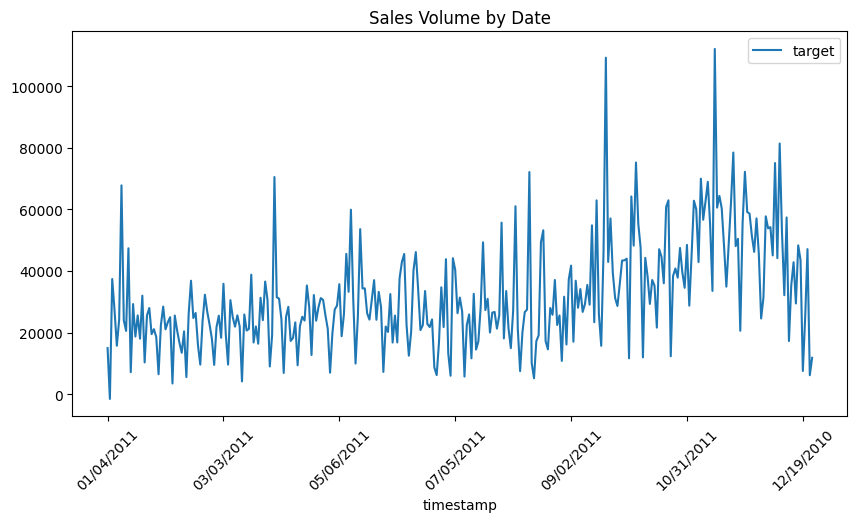

In [8]:
df_sample.loc['online_sales']['target'].plot(
    title='Sales Volume by Date',
    figsize=(10,5),
    rot=45,
    legend=True
)
plt.savefig('assets/AutoGluon_AutoML_TimeSeries_01.webp', bbox_inches='tight')

![AutoML with AutoGluon for Timeseries Data](./assets/AutoGluon_AutoML_TimeSeries_01.webp)

In [17]:
df_sample.to_csv('dataset/single_variant_ts.csv', index=True)

### Model Training

> ValueError: Frequency not provided and cannot be inferred. This is often due to the time index of the data being 
irregularly sampled. Please ensure that the data set used has a uniform time index, or create the 
`TimeSeriesPredictor` setting `ignore_time_index=True`.

AutoGluon does not like irregular timeseries __AT ALL__... I manually fixed the `timestamp` column with regular, daily interval. Docs recommend auto-filling for missing data before model training.

In [3]:
train_data = TimeSeriesDataFrame('dataset/single_variant_ts.csv')
train_data.describe()

,target
count,285.000000
mean,31574.704961
std,17448.848440
min,-1566.230000
25%,20660.030000
50%,27233.140000
75%,39426.480000
max,112141.110000


|  | target |
| -- | -- |
| count | 305.000000 |
| mean | 31959.829292 |
| std | 17414.261664 |
| min | -1566.230000 |
| 25% | 20728.140000 |
| 50% | 27978.410000 |
| 75% | 42912.400000 |
| max | 112141.110000 |

In [4]:
# create a predictor for 30 days (30 row in dataset) forcast
sv_predictor = TimeSeriesPredictor(
    prediction_length=30,
    path=MODEL_PATH,
    target='target',
    eval_metric='sMAPE'
)

In [5]:
sv_predictor.fit(
    train_data,
    time_limit=800,
    presets="medium_quality"
)

# Training complete. Models trained: ['Naive', 'SeasonalNaive', 'Theta', 'AutoETS', 'RecursiveTabular', 'DeepAR', 'WeightedEnsemble']
# Total runtime: 146.36 s
# Best model: WeightedEnsemble
# Best model score: -0.2301

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'num_val_windows': 1,
 'prediction_length': 30,
 'random_seed': None,
 'target': 'target',
 'time_limit': 800,
 'verbosity': 2}
Provided training data set with 285 rows, 1 items (item = single time series). Average time series length is 285.0. Data frequency is 'D'.
AutoGluon will save models to model/
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'

Starting training. Start time is 2023-06-24 16:43:11
Models that will be trained: ['Naive'

In [6]:
sv_predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -0.230084       7.123511           2.275487          7
1             Naive  -0.243808       5.931596           0.011237          1
2  RecursiveTabular  -0.310910       1.061646           1.976520          5
3             Theta  -0.336442      25.783803           0.010182          3
4           AutoETS  -0.353730      22.926880           0.008008          4
5     SeasonalNaive  -0.381436       5.123216           0.009549          2
6            DeepAR  -0.414007       0.130269          80.861033          6
Number of models trained: 7
Types of models trained:
{'MultiWindowBacktestingModel', 'TimeSeriesGreedyEnsemble'}
****************** End of fit() summary ******************


{'model_types': {'Naive': 'MultiWindowBacktestingModel',
  'SeasonalNaive': 'MultiWindowBacktestingModel',
  'Theta': 'MultiWindowBacktestingModel',
  'AutoETS': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DeepAR': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'Naive': -0.2438081721823558,
  'SeasonalNaive': -0.3814356666641861,
  'Theta': -0.3364419856758003,
  'AutoETS': -0.3537296977838615,
  'RecursiveTabular': -0.3109097415508591,
  'DeepAR': -0.4140065193184801,
  'WeightedEnsemble': -0.2300837925037088},
 'model_best': 'WeightedEnsemble',
 'model_paths': {'Naive': 'model/models/Naive/',
  'SeasonalNaive': 'model/models/SeasonalNaive/',
  'Theta': 'model/models/Theta/',
  'AutoETS': 'model/models/AutoETS/',
  'RecursiveTabular': 'model/models/RecursiveTabular/',
  'DeepAR': 'model/models/DeepAR/',
  'WeightedEnsemble': 'model/models/WeightedEnsemble/'},
 'model_fit_times': {'Naiv

Estimated performance of each model:

|   |     model | score_val | pred_time_val | fit_time_marginal | fit_order |
|  -- |     -- | -- | -- | -- | -- |
| 0 | WeightedEnsemble | -0.321595 | 1.042651 | 1.881647 | 7 |
| 1 | RecursiveTabular | -0.321595 | 1.042651 | 0.757291 | 5 |
| 2 | DeepAR | -0.384756 | 0.095033 | 69.751811 | 6 |
| 3 | AutoETS | -0.385364 | 22.865800 | 0.012004 | 4 |
| 4 | Theta | -0.397785 | 24.269135 | 0.009619 | 3 |
| 5 | SeasonalNaive | -0.403544 | 5.162711 | 0.010179 | 2 |
| 6 | Naive | -0.403544 | 5.572433 | 0.009085 | 1 |
_Number of models trained: 7_
_Types of models trained:_
`{'MultiWindowBacktestingModel', 'TimeSeriesGreedyEnsemble'}`

### Model Evaluation

In [7]:
# return a 1 month forcast on the training data
sv_predictions = sv_predictor.predict(train_data, random_seed=SEED)

Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [8]:
sv_predictions

mean           0.1           0.2  \
item_id      timestamp                                              
online_sales 2011-10-16  35231.549892  14821.287291  21889.080854   
             2011-10-17  37319.098400   9315.489680  18992.518673   
             2011-10-18  38623.633612   5142.371285  16610.764052   
             2011-10-19  40741.301758   1946.154973  15539.068760   
             2011-10-20  49296.101707   6303.232915  21458.815514   
             2011-10-21  42399.179004  -4222.418692  11966.114749   
             2011-10-22  33619.926637 -17087.154419    364.144617   
             2011-10-23  39042.384772 -14703.540432   3853.552955   
             2011-10-24  37314.733017 -19270.824930    233.744114   
             2011-10-25  40035.277581 -19730.031575    823.364529   
             2011-10-26  43809.551647 -18581.300915   2831.155428   
             2011-10-27  40978.233969 -24604.018712  -2246.682396   
             2011-10-28  41743.192227 -26024.978536  -2645.385307   
             2011-10-29  38315.939169 -32037.733749  -7961.047361   
             2011-10-30  40790.730787 -31714.294692  -6632.032918   
             2011-10-31  39601.428364 -35269.325656  -9299.692907   
             2011-11-01  43321.091336 -33495.290752  -7238.416761   
             2011-11-02  39873.310897 -39638.237188 -12259.488831   
             2011-11-03  38897.212691 -42509.220460 -14725.370733   
             2011-11-04  45310.748490 -37919.694783  -9357.164960   
             2011-11-05  40524.113111 -45095.463685 -15760.925828   
             2011-11-06  40806.692620 -46676.736613 -16544.120931   
             2011-11-07  43503.676450 -46255.703438 -15315.077993   
             2011-11-08  39830.233893 -51545.615185 -20027.924158   
             2011-11-09  36990.513044 -56523.526649 -24495.447993   
             2011-11-10  42656.625332 -52222.084277 -19714.514788   
             2011-11-11  44756.329828 -52548.031615 -18656.197064   
             2011-11-12  37905.655743 -60991.102805 -27099.347751   
             2011-11-13  44715.800505 -55633.323514 -20782.285358   
             2011-11-14  38863.458282 -62877.590928 -28234.112477   

                                  0.3           0.4           0.5  \
item_id      timestamp                                              
online_sales 2011-10-16  26885.810628  31139.108555  35389.176845   
             2011-10-17  25927.428089  31800.990269  37256.964611   
             2011-10-18  24909.974641  32018.253338  38569.692694   
             2011-10-19  25137.953113  33223.044572  40765.606934   
             2011-10-20  31910.941266  40964.792632  49394.712059   
             2011-10-21  23324.147218  33287.622759  42457.754199   
             2011-10-22  12901.404480  23491.862364  33662.238893   
             2011-10-23  17218.430626  28519.710014  39090.598639   
             2011-10-24  14092.680263  26011.109933  37258.663681   
             2011-10-25  15754.378083  28379.185360  40095.125237   
             2011-10-26  18233.929143  31493.221895  43799.325572   
             2011-10-27  14204.335705  28124.915072  41120.107016   
             2011-10-28  14166.811130  28273.284258  41561.178311   
             2011-10-29   9530.292590  24433.420394  38430.213583   
             2011-10-30  11250.135692  26624.395493  40830.333814   
             2011-10-31   9073.426874  24982.993094  39702.658833   
             2011-11-01  11718.451027  27982.345746  43267.875515   
             2011-11-02   7259.635658  24107.774345  39944.400252   
             2011-11-03   5465.492686  22784.085743  38756.254195   
             2011-11-04  11175.946162  28815.300995  45152.634721   
             2011-11-05   5668.926472  23679.488279  40503.121411   
             2011-11-06   5068.030397  23563.217104  40845.487542   
             2011-11-07   6965.648074  25902.252457  43336.311215   
             2011-11-08   2662.824619  21906.346012  39980.482428   
             2011-11-09  -1066

|         |    | mean | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 |
| --      | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| item_id      | timestamp  |  |  |  |  |  |  |  |  |  |  |									
| online_sales | 2011-10-16 | 35231.549892 | 14821.287291 | 21889.080854 | 26885.810628 | 31139.108555 | 35389.176845 | 39525.311786 | 43747.076754 | 48715.574839 | 55619.827997 |
|              | 2011-10-17 | 37319.098400 | 9315.489680 | 18992.518673 | 25927.428089 | 31800.990269 | 37256.964611 | 42685.962390 | 48685.278476 | 55741.918605 | 65278.986905 |
|              | 2011-10-18 | 38623.633612 | 5142.371285 | 16610.764052 | 24909.974641 | 32018.253338 | 38569.692694 | 45201.922577 | 52390.855571 | 60646.930906 | 72387.928409 |
|              | 2011-10-19 | 40741.301758 | 1946.154973 | 15539.068760 | 25137.953113 | 33223.044572 | 40765.606934 | 48463.165389 | 56628.990736 | 66077.743741 | 79722.836483 |
|              | 2011-10-20 | 49296.101707 | 6303.232915 | 21458.815514 | 31910.941266 | 40964.792632 | 49394.712059 | 57908.461563 | 66841.601504 | 77474.686240 | 92186.915812 |
|              | 2011-10-21 | 42399.179004 | -4222.418692 | 11966.114749 | 23324.147218 | 33287.622759 | 42457.754199 | 51587.049946 | 61400.403661 | 72842.296970 | 88931.093472 |
|              | 2011-10-22 | 33619.926637 | -17087.154419 | 364.144617 | 12901.404480 | 23491.862364 | 33662.238893 | 43520.884464 | 54164.964907 | 66630.573647 | 84037.471194 |
|              | 2011-10-23 | 39042.384772 | -14703.540432 | 3853.552955 | 17218.430626 | 28519.710014 | 39090.598639 | 49763.392538 | 60939.668264 | 74324.111121 | 92676.374673 |
|              | 2011-10-24 | 37314.733017 | -19270.824930 | 233.744114 | 14092.680263 | 26011.109933 | 37258.663681 | 48286.522116 | 60254.494754 | 74152.628169 | 93725.394967 |
|              | 2011-10-25 | 40035.277581 | -19730.031575 | 823.364529 | 15754.378083 | 28379.185360 | 40095.125237 | 51768.504080 | 64369.746415 | 78969.545369 | 99392.125068 |
|              | 2011-10-26 | 43809.551647 | -18581.300915 | 2831.155428 | 18233.929143 | 31493.221895 | 43799.325572 | 56059.960500 | 69262.074053 | 84846.687611 | 106247.592685 |
|              | 2011-10-27 | 40978.233969 | -24604.018712 | -2246.682396 | 14204.335705 | 28124.915072 | 41120.107016 | 53865.685435 | 67632.214997 | 83850.112737 | 106498.851884 |
|              | 2011-10-28 | 41743.192227 | -26024.978536 | -2645.385307 | 14166.811130 | 28273.284258 | 41561.178311 | 54943.112404 | 69180.700278 | 86004.451402 | 109515.329421 |
|              | 2011-10-29 | 38315.939169 | -32037.733749 | -7961.047361 | 9530.292590 | 24433.420394 | 38430.213583 | 52199.831968 | 67014.321833 | 84580.597330 | 108781.710477 |
|              | 2011-10-30 | 40790.730787 | -31714.294692 | -6632.032918 | 11250.135692 | 26624.395493 | 40830.333814 | 55083.397136 | 70254.854690 | 88116.212266 | 113018.777994 |
|              | 2011-10-31 | 39601.428364 | -35269.325656 | -9299.692907 | 9073.426874 | 24982.993094 | 39702.658833 | 54402.247423 | 70171.210127 | 88614.257154 | 114229.722423 |
|              | 2011-11-01 | 43321.091336 | -33495.290752 | -7238.416761 | 11718.451027 | 27982.345746 | 43267.875515 | 58529.011730 | 74809.030961 | 93805.173651 | 120492.849400 |
|              | 2011-11-02 | 39873.310897 | -39638.237188 | -12259.488831 | 7259.635658 | 24107.774345 | 39944.400252 | 55573.550817 | 72172.974172 | 91871.915068 | 119270.200045 |
|              | 2011-11-03 | 38897.212691 | -42509.220460 | -14725.370733 | 5465.492686 | 22784.085743 | 38756.254195 | 54814.426553 | 72198.679766 | 92621.915745 | 120534.229094 |
|              | 2011-11-04 | 45310.748490 | -37919.694783 | -9357.164960 | 11175.946162 | 28815.300995 | 45152.634721 | 61626.068300 | 79239.016639 | 99980.063552 | 128811.104239 |
|              | 2011-11-05 | 40524.113111 | -45095.463685 | -15760.925828 | 5668.926472 | 23679.488279 | 40503.121411 | 57398.500638 | 75497.467474 | 96633.997752 | 126117.225307 |
|              | 2011-11-06 | 40806.692620 | -46676.736613 | -16544.120931 | 5068.030397 | 23563.217104 | 40845.487542 | 58063.833664 | 76565.798203 | 98222.894111 | 128465.220975 |
|              | 2011-11-07 | 43503.676450 | -46255.703438 | -15315.077993 | 6965.648074 | 25902.252457 | 43336.311215 | 61053.512552 | 80111.716545 | 102295.131332 | 133194.560977 |
|              | 2011-11-08 | 39830.233893 | -51545.615185 | -20027.924158 | 2662.824619 | 21906.346012 | 39980.482428 | 58006.295602 | 77399.156839 | 99888.163672 | 131151.589197 |
|              | 2011-11-09 | 36990.513044 | -56523.526649 | -24495.447993 | -1066.945972 | 18732.001915 | 37151.279157 | 55520.419680 | 75331.859267 | 98382.970785 | 130468.262942 |
|              | 2011-11-10 | 42656.625332 | -52222.084277 | -19714.514788 | 3802.223665 | 23887.046793 | 42525.441250 | 61225.057142 | 81332.468161 | 104820.044505 | 137808.305522 |
|              | 2011-11-11 | 44756.329828 | -52548.031615 | -18656.197064 | 5288.754038 | 25734.360637 | 44828.240961 | 63986.351020 | 84378.816506 | 108611.618683 | 142140.108263 |
|              | 2011-11-12 | 37905.655743 | -60991.102805 | -27099.347751 | -2388.499412 | 18511.776221 | 38050.389629 | 57546.974229 | 78416.261580 | 102719.966853 | 136415.925032 |
|              | 2011-11-13 | 44715.800505 | -55633.323514 | -20782.285358 | 3913.667987 | 24980.451031 | 44809.798552 | 64605.937576 | 85704.112222 | 110433.920792 | 144866.205041 |
|              | 2011-11-14 | 38863.458282 | -62877.590928 | -28234.112477 | -2844.261356 | 18802.531926 | 38951.660430 | 59170.908563 | 80678.533877 | 105966.185779 | 141098.465744 |

#### Visualization

In [70]:
def plot_predictions(train_data, predictions, item_id, target_column, titel, ylabel):
    plt.figure(figsize=(12,5))
    plt.title(titel)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    # timeseries data
    y_train = train_data.loc[item_id][target_column]
    plt.plot(y_train, label="Timeseries Data")
    # forcast data
    y_pred = predictions.loc[item_id]
    plt.plot(y_pred['mean'], label="Mean Forecast")
    # confidence intervals
    plt.fill_between(
        y_pred.index , y_pred['0.1'], y_pred['0.9'],
        color='red', alpha=0.1, label='10%-90% Confidence Range'
    )

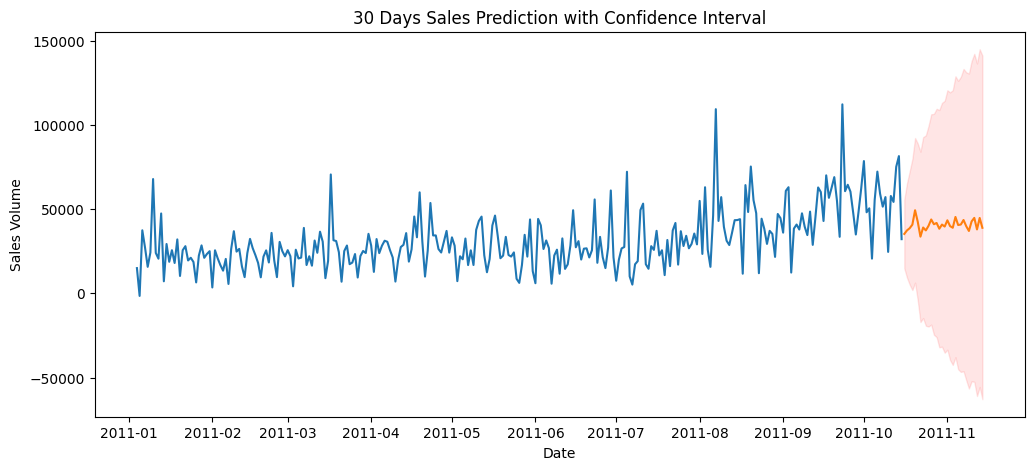

In [25]:
plot_predictions(
    train_data, sv_predictions,
    item_id='online_sales', target_column='target',
    titel='30 Days Sales Prediction with Confidence Interval',
    ylabel = 'Sales Volume'
)
plt.savefig('assets/AutoGluon_AutoML_TimeSeries_02.webp', bbox_inches='tight')

![AutoML with AutoGluon for Timeseries Data](./assets/AutoGluon_AutoML_TimeSeries_02.webp)

## Multi Variate Forecasting - Future Covariants

Add known factors that affected your time series data in the past to future prediction - e.g. holidays on restaurant revenues.

In [1]:
# get dataset
!wget https://github.com/DaviRolim/datasets/raw/master/RestaurantVisitors.csv -P dataset

--2023-06-24 19:14:37--  https://github.com/DaviRolim/datasets/raw/master/RestaurantVisitors.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DaviRolim/datasets/master/RestaurantVisitors.csv [following]
--2023-06-24 19:14:38--  https://raw.githubusercontent.com/DaviRolim/datasets/master/RestaurantVisitors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19920 (19K) [text/plain]
Saving to: ‘dataset/RestaurantVisitors.csv’

RestaurantVisitors. 100%[===================>]  19.45K  --.-KB/s    in 0.01s   

2023-06-24 19:14:39 (1.49 

### Data Preprocessing

In [21]:
df = pd.read_csv('dataset/RestaurantVisitors.csv')
df.tail(5)
# dataset contains unknowns -> will be used for prediction

,date,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
512,5/27/2017,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
513,5/28/2017,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
514,5/29/2017,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
515,5/30/2017,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
516,5/31/2017,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


|  | date | weekday | holiday | holiday_name | rest1 | rest2 | rest3 | rest4 | total |
| --  | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 512 | 5/27/2017 | Saturday | 0 | na | NaN | NaN | NaN | NaN | NaN |
| 513 | 5/28/2017 | Sunday | 0 | na | NaN | NaN | NaN | NaN | NaN |
| 514 | 5/29/2017 | Monday | 1 | Memorial Day | NaN | NaN | NaN | NaN | NaN |
| 515 | 5/30/2017 | Tuesday | 0 | na | NaN | NaN | NaN | NaN | NaN |
| 516 | 5/31/2017 | Wednesday | 0 | na | NaN | NaN | NaN | NaN | NaN |

In [15]:
df.info()
# there are `517` entries but only `478` have a total

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          517 non-null    object 
 1   weekday       517 non-null    object 
 2   holiday       517 non-null    int64  
 3   holiday_name  517 non-null    object 
 4   rest1         478 non-null    float64
 5   rest2         478 non-null    float64
 6   rest3         478 non-null    float64
 7   rest4         478 non-null    float64
 8   total         478 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 36.5+ KB


|    | Column | Non-Null Count | Dtype |
| -- | -- | -- | -- |
 | 0 |date |  |   517 non-null | object  |
 | 1 |weekday |    517 non-null | object  |
 | 2 |holiday |    517 non-null | int64   |
 | 3 |holiday_name | 517 non-null | object  |
 | 4 |rest1  |  478 non-null | float64 |
 | 5 |rest2  |  478 non-null | float64 |
 | 6 |rest3  |  478 non-null | float64 |
 | 7 |rest4  |  478 non-null | float64 |
 | 8 |total  |  478 non-null | float64 |

In [28]:
df_sample = df.copy()

# renaming columns
df_sample.rename(columns={'total': 'target', 'date': 'timestamp'}, inplace=True)
df_sample['item_id'] = 'restaurant_visitors'

# get numeric representation of weekday from timestamp
datetimes = pd.to_datetime(df_sample['timestamp'])
df_sample['timestamp'] = datetimes
df_sample['weekday'] = datetimes.dt.day_of_week

# drop not needed
df_sample.drop(
    ['rest1', 'rest2', 'rest3', 'rest4', 'holiday_name'],
    axis=1, inplace=True)

df_sample.tail(5)

,timestamp,weekday,holiday,target,item_id
512,2017-05-27,5,0,NaN,restaurant_visitors
513,2017-05-28,6,0,NaN,restaurant_visitors
514,2017-05-29,0,1,NaN,restaurant_visitors
515,2017-05-30,1,0,NaN,restaurant_visitors
516,2017-05-31,2,0,NaN,restaurant_visitors


|  | timestamp | weekday | holiday | target | item_id |
| -- | -- | -- | -- | -- | -- |
| 512 | 2017-05-27 | 5 | 0 | NaN | restaurant_visitors |
| 513 | 2017-05-28 | 6 | 0 | NaN | restaurant_visitors |
| 514 | 2017-05-29 | 0 | 1 | NaN | restaurant_visitors |
| 515 | 2017-05-30 | 1 | 0 | NaN | restaurant_visitors |
| 516 | 2017-05-31 | 2 | 0 | NaN | restaurant_visitors |

In [32]:
# split missing data for prediction
df_sample.iloc[:478].to_csv('dataset/mv_known_series.csv', index=False)
df_sample.iloc[478:].drop('target',axis=1).to_csv('dataset/mv_unknown_series.csv', index=False)

### Model Training

In [33]:
train_data = TimeSeriesDataFrame('dataset/mv_known_series.csv')
train_data.head(5)

weekday  holiday  target
item_id             timestamp                           
restaurant_visitors 2016-01-01        4        1   296.0
                    2016-01-02        5        0   191.0
                    2016-01-03        6        0   202.0
                    2016-01-04        0        0   105.0
                    2016-01-05        1        0    98.0

|  |  | weekday | holiday | target |
| -- | -- | -- | -- | -- |
| item_id | timestamp |  |  |  |
| restaurant_visitors | 2016-01-01 | 4 | 1 | 296.0 |
|  | 2016-01-02 | 5 | 0 | 191.0 |
|  | 2016-01-03 | 6 | 0 | 202.0 |
|  | 2016-01-04 | 0 | 0 | 105.0 |
|  | 2016-01-05 | 1 | 0 | 98.0 |

In [37]:
# create a predictor for the length of the unknown series
mv_predictor = TimeSeriesPredictor(
    prediction_length=len(df_sample.iloc[478:]),
    path=MODEL_PATH,
    target='target',
    known_covariates_names = ['weekday', 'holiday'],
    eval_metric='sMAPE'
)

In [38]:
mv_predictor.fit(
    train_data,
    time_limit=800,
    presets="high_quality"
)

# Training complete. Models trained: ['Naive', 'SeasonalNaive', 'Theta', 'AutoETS', 'RecursiveTabular', 'DeepAR', 'TemporalFusionTransformer', 'PatchTST', 'AutoARIMA', 'WeightedEnsemble']
# Total runtime: 470.02 s
# Best model: WeightedEnsemble
# Best model score: -0.1501

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: high_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'high_quality',
 'num_val_windows': 1,
 'prediction_length': 39,
 'random_seed': None,
 'target': 'target',
 'time_limit': 800,
 'verbosity': 2}
Provided training data set with 478 rows, 1 items (item = single time series). Average time series length is 478.0. Data frequency is 'D'.
AutoGluon will save models to model/
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'
	known covariates: ['weekday', 'holiday']

Starting training. Start time is 2023-06-24 20:14:34

### Model Predictions

In [39]:
future_series = TimeSeriesDataFrame('dataset/mv_unknown_series.csv')

In [40]:
future_series.head(5)

weekday  holiday
item_id             timestamp                   
restaurant_visitors 2017-04-23        6        0
                    2017-04-24        0        0
                    2017-04-25        1        0
                    2017-04-26        2        0
                    2017-04-27        3        0

|  |  | weekday | holiday |
| -- | -- | -- | -- |
| item_id | timestamp |  |  |
| restaurant_visitors | 2017-04-23 | 6 | 0 |
|  | 2017-04-24 | 0 | 0 |
|  | 2017-04-25 | 1 | 0 |
|  | 2017-04-26 | 2 | 0 |
|  | 2017-04-27 | 3 | 0 |

In [42]:
mv_predictions = mv_predictor.predict(train_data, known_covariates=future_series, random_seed=SEED)

Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


#### Visualization

In [67]:
plot_predictions(
    train_data, mv_predictions,
    item_id='restaurant_visitors', target_column='target',
    titel='Restaurant Visitors 39 Days Predictions with Confidence Interval',
    ylabel = 'Restaurant Revenue'
)
plt.savefig('assets/AutoGluon_AutoML_TimeSeries_03.webp', bbox_inches='tight')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_80892/2487787476.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_80892/2487787476.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'plot_predictions' is not defined

![AutoML with AutoGluon for Timeseries Data](./assets/AutoGluon_AutoML_TimeSeries_03.webp)

## Multi Variate Forecasting - Past Covariants

The Air Quality dataset reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China. The data includes the date-time, the PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain.

In [1]:
# get dataset
!wget https://raw.githubusercontent.com/jyoti0225/Air-Pollution-Forecasting/master/AirPollution.csv -P dataset

--2023-06-24 20:47:37--  https://raw.githubusercontent.com/jyoti0225/Air-Pollution-Forecasting/master/AirPollution.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010494 (1.9M) [text/plain]
Saving to: ‘dataset/AirPollution.csv’

AirPollution.csv    100%[===================>]   1.92M  1.10MB/s    in 1.7s    

2023-06-24 20:47:40 (1.10 MB/s) - ‘dataset/AirPollution.csv’ saved [2010494/2010494]



### Data Preprocessing

In [12]:
# datetime is split up into 4 columns => combine
def parse(x):
    return dt.strptime(x, '%Y %m %d %H')

In [52]:
df = pd.read_csv('dataset/AirPollution.csv', date_parser=parse,parse_dates=[
    ['year', 'month', 'day', 'hour']
])

df.head(5)

,year_month_day_hour,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


| | year_month_day_hour | No | pm2.5 | DEWP | TEMP | PRES | cbwd | Iws | Is | Ir |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | 2010-01-01 00:00:00 | 1 | NaN | -21 | -11.0 | 1021.0 | NW | 1.79 | 0 | 0 |
| 1 | 2010-01-01 01:00:00 | 2 | NaN | -21 | -12.0 | 1020.0 | NW | 4.92 | 0 | 0 |
| 2 | 2010-01-01 02:00:00 | 3 | NaN | -21 | -11.0 | 1019.0 | NW | 6.71 | 0 | 0 |
| 3 | 2010-01-01 03:00:00 | 4 | NaN | -21 | -14.0 | 1019.0 | NW | 9.84 | 0 | 0 |
| 4 | 2010-01-01 04:00:00 | 5 | NaN | -20 | -12.0 | 1018.0 | NW | 12.97 | 0 | 0 |

In [15]:
df.info()
# dataset contains missing pm2.5 values

#  #   Column               Non-Null Count  Dtype         
# ---  ------               --------------  -----         
#  0   year_month_day_hour  43824 non-null  datetime64[ns]
#  1   No                   43824 non-null  int64         
#  2   pm2.5                41757 non-null  float64       
#  3   DEWP                 43824 non-null  int64         
#  4   TEMP                 43824 non-null  float64       
#  5   PRES                 43824 non-null  float64       
#  6   cbwd                 43824 non-null  object        
#  7   Iws                  43824 non-null  float64       
#  8   Is                   43824 non-null  int64         
#  9   Ir                   43824 non-null  int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year_month_day_hour  43824 non-null  datetime64[ns]
 1   No                   43824 non-null  int64         
 2   pm2.5                41757 non-null  float64       
 3   DEWP                 43824 non-null  int64         
 4   TEMP                 43824 non-null  float64       
 5   PRES                 43824 non-null  float64       
 6   cbwd                 43824 non-null  object        
 7   Iws                  43824 non-null  float64       
 8   Is                   43824 non-null  int64         
 9   Ir                   43824 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 3.3+ MB


In [61]:
df_sample = df.copy()

# one-hot encode wind direction
one_hot_wind = pd.get_dummies(df['cbwd'], drop_first=True)
df_sample = pd.concat([df, one_hot_wind], axis=1, join="inner")

# renaming columns
df_sample.rename(columns={
    'year_month_day_hour': 'timestamp',
    'pm2.5': 'target',
    'DEWP': 'dew_point',
    'TEMP': 'temperature',
    'PRES': 'pressure',
    'NW': 'wind_direction_nw',
    'SE': 'wind_direction_se',
    'cv': 'wind_direction_cv',
    'Iws': 'wind_speed',
    'Is': 'snow',
    'Ir': 'rain'}, inplace=True)

# add item_id
df_sample['item_id'] = 'pm2_pollution'

# fill missing targets with mean()
df_sample['target'] = df_sample['target'].fillna(df_sample['target'].mean())

# make datetime object
datetimes = pd.to_datetime(df_sample['timestamp'])
df_sample['timestamp'] = datetimes
df_sample['weekday'] = datetimes.dt.day_of_week

# drop not needed
df_sample.drop(['No', 'cbwd'], axis=1, inplace=True)

df_sample.head(5)

,timestamp,target,dew_point,temperature,pressure,wind_speed,snow,rain,wind_direction_nw,wind_direction_se,wind_direction_cv,item_id,weekday
0,2010-01-01 00:00:00,98.613215,-21,-11.0,1021.0,1.79,0,0,1,0,0,pm2_pollution,4
1,2010-01-01 01:00:00,98.613215,-21,-12.0,1020.0,4.92,0,0,1,0,0,pm2_pollution,4
2,2010-01-01 02:00:00,98.613215,-21,-11.0,1019.0,6.71,0,0,1,0,0,pm2_pollution,4
3,2010-01-01 03:00:00,98.613215,-21,-14.0,1019.0,9.84,0,0,1,0,0,pm2_pollution,4
4,2010-01-01 04:00:00,98.613215,-20,-12.0,1018.0,12.97,0,0,1,0,0,pm2_pollution,4


|  | timestamp | target | dew_point | temperature | pressure | wind_speed | snow | rain | wind_direction_nw | wind_direction_se | wind_direction_cv | item_id | weekday |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | 2010-01-01 00:00:00 | 98.613215 | -21 | -11.0 | 1021.0 | 1.79 | 0 | 0 | 1 | 0 | 0 | pm2_pollution | 4 |
| 1 | 2010-01-01 01:00:00 | 98.613215 | -21 | -12.0 | 1020.0 | 4.92 | 0 | 0 | 1 | 0 | 0 | pm2_pollution | 4 |
| 2 | 2010-01-01 02:00:00 | 98.613215 | -21 | -11.0 | 1019.0 | 6.71 | 0 | 0 | 1 | 0 | 0 | pm2_pollution | 4 |
| 3 | 2010-01-01 03:00:00 | 98.613215 | -21 | -14.0 | 1019.0 | 9.84 | 0 | 0 | 1 | 0 | 0 | pm2_pollution | 4 |
| 4 | 2010-01-01 04:00:00 | 98.613215 | -20 | -12.0 | 1018.0 | 12.97 | 0 | 0 | 1 | 0 | 0 | pm2_pollution | 4 |

In [62]:
df_sample.to_csv('dataset/bj_airpollution.csv', index=False)

### Model Training

In [63]:
train_data = TimeSeriesDataFrame('dataset/bj_airpollution.csv')
train_data.head(5)

target  dew_point  temperature  \
item_id       timestamp                                                
pm2_pollution 2010-01-01 00:00:00  98.613215        -21        -11.0   
              2010-01-01 01:00:00  98.613215        -21        -12.0   
              2010-01-01 02:00:00  98.613215        -21        -11.0   
              2010-01-01 03:00:00  98.613215        -21        -14.0   
              2010-01-01 04:00:00  98.613215        -20        -12.0   

                                   pressure  wind_speed  snow  rain  \
item_id       timestamp                                               
pm2_pollution 2010-01-01 00:00:00    1021.0        1.79     0     0   
              2010-01-01 01:00:00    1020.0        4.92     0     0   
              2010-01-01 02:00:00    1019.0        6.71     0     0   
              2010-01-01 03:00:00    1019.0        9.84     0     0   
              2010-01-01 04:00:00    1018.0       12.97     0     0   

                                   wind_direction_nw  wind_direction_se  \
item_id       timestamp                                                   
pm2_pollution 2010-01-01 00:00:00                  1                  0   
              2010-01-01 01:00:00                  1                  0   
              2010-01-01 02:00:00                  1                  0   
              2010-01-01 03:00:00                  1                  0   
              2010-01-01 04:00:00                  1                  0   

                                   wind_direction_cv  weekday  
item_id       timestamp                                        
pm2_pollution 2010-01-01 00:00:00                  0        4  
              2010-01-01 01:00:00                  0        4  
              2010-01-01 02:00:00                  0        4  
              2010-01-01 03:00:00                  0        4  
              2010-01-01 04:00:00                  0        4

|         |           | target | dew_point | temperature | pressure | wind_speed | snow | rain | wind_direction_nw | wind_direction_se | wind_direction_cv | weekday |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | --  |
| item_id | timestamp |  |  |  |  |  |  |  | |  |  |   |
| pm2_pollution | 2010-01-01 00:00:00 | 98.613215 | -21 | -11.0 | 1021.0 | 1.79 | 0 | 0 | 1 | 0 | 0 | 4 |
| | 2010-01-01 01:00:00 | 98.613215 | -21 | -12.0 | 1020.0 | 4.92 | 0 | 0 | 1 | 0 | 0 | 4 |
| | 2010-01-01 02:00:00 | 98.613215 | -21 | -11.0 | 1019.0 | 6.71 | 0 | 0 | 1 | 0 | 0 | 4 |
| | 2010-01-01 03:00:00 | 98.613215 | -21 | -14.0 | 1019.0 | 9.84 | 0 | 0 | 1 | 0 | 0 | 4 |
| | 2010-01-01 04:00:00 | 98.613215 | -20 | -12.0 | 1018.0 | 12.97 | 0 | 0 | 1 | 0 | 0 | 4 |

In [64]:
# 30-day predictor
bj_predictor = TimeSeriesPredictor(
    prediction_length=24*30,
    path=MODEL_PATH,
    target='target',
    eval_metric='sMAPE'
)

In [65]:
bj_predictor.fit(
    train_data,
    presets="high_quality"
)

# Fitting simple weighted ensemble.
# 	-0.8465       = Validation score (-sMAPE)
# 	3.16    s     = Training runtime
# 	40.20   s     = Validation (prediction) runtime
# Training complete. Models trained: ['Naive', 'SeasonalNaive', 'Theta', 'AutoETS', 'RecursiveTabular', 'DeepAR', 'PatchTST', 'AutoARIMA', 'WeightedEnsemble']
# Total runtime: 693.53 s
# Best model: WeightedEnsemble
# Best model score: -0.8465

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: high_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'high_quality',
 'num_val_windows': 1,
 'prediction_length': 720,
 'random_seed': None,
 'target': 'target',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 43824 rows, 1 items (item = single time series). Average time series length is 43824.0. Data frequency is 'H'.
AutoGluon will save models to model/
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'
	past covariates:  ['dew_point', 'temperature', 'pressure', 'wind_speed', 'snow', 'rain',

### Model Predictions

In [66]:
bj_predictions = bj_predictor.predict(train_data, random_seed=SEED)

Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


#### Visualization

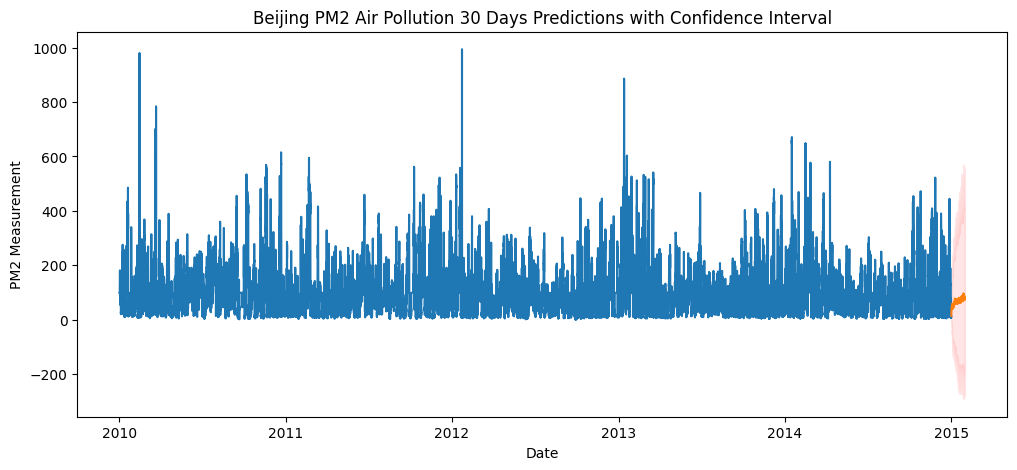

In [71]:
plot_predictions(
    train_data, bj_predictions,
    item_id='pm2_pollution', target_column='target',
    titel='Beijing PM2 Air Pollution 30 Days Predictions with Confidence Interval',
    ylabel = 'PM2 Measurement'
)
plt.savefig('assets/AutoGluon_AutoML_TimeSeries_04.webp', bbox_inches='tight')

![AutoML with AutoGluon for Timeseries Data](./assets/AutoGluon_AutoML_TimeSeries_04.webp)